<a href="https://colab.research.google.com/github/suhaodatascichem/Methionine-price/blob/main/Methionine_price_weekly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [1]:
# required libraries
import pandas as pd
import numpy as np
import datetime as dt

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import MinMaxScaler
import math, time
from sklearn.metrics import mean_squared_error
import time
from sklearn.metrics import mean_squared_error

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Read Data

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/suhaodatascichem/Methionine-price/f03e43d1167e30719338fa20fbd1b3a4fc844599/Indonesia%20daily%20import%20data%20-%20Copy%20for%20Su%20Hao%20(1).xlsx"
df_raw = pd.read_excel(url, engine="openpyxl")

In [5]:
df_raw.head(10)

,Date,Sum of CIF gross price(USD),Sum of Quantity in kg,Price
0,2023-01-02,558000.0,180000,3.100000
1,2023-01-03,561642.0,201820,2.782886
2,2023-01-04,132000.0,60000,2.200000
3,2023-01-05,45000.0,20000,2.250000
4,2023-01-09,92800.0,40000,2.320000
5,2023-01-10,46000.0,20000,2.300000
6,2023-01-11,125740.0,56000,2.245357
7,2023-01-13,225000.0,100000,2.250000
8,2023-01-16,186000.0,60000,3.100000
9,2023-01-17,545186.0,220060,2.477443


In [6]:
df_raw["Date"] = pd.to_datetime(df_raw["Date"])

In [7]:
startdate = df_raw['Date'].min()
print('startdate is ', startdate)
enddate = df_raw['Date'].max()
print("enddate is ", enddate)


startdate is  2023-01-02 00:00:00
enddate is  2025-01-31 00:00:00


In [8]:
df_raw.head(1)

,Date,Sum of CIF gross price(USD),Sum of Quantity in kg,Price
0,2023-01-02,558000.0,180000,3.1


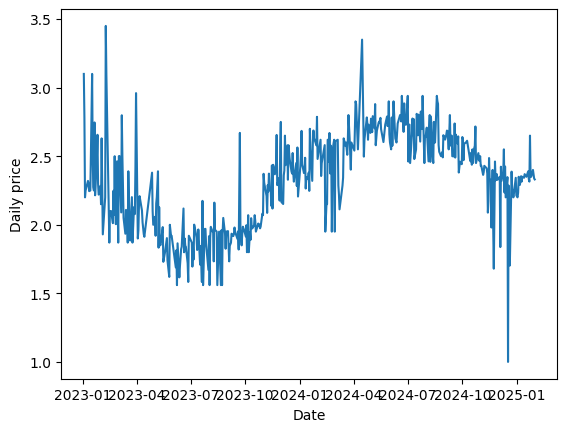

<Figure size 3200x200 with 0 Axes>

In [9]:
plt.plot(df_raw['Date'], df_raw["Price"])
plt.xlabel("Date")
plt.ylabel("Daily price")
plt.figure(figsize=(32,2))
plt.show()

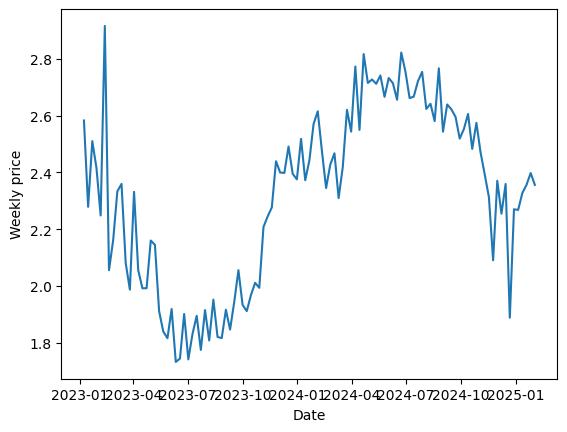

<Figure size 3200x200 with 0 Axes>

In [10]:
df_weekly = df_raw.resample('W', on='Date').mean().reset_index()
# foward fill missing values
df_weekly = df_weekly.ffill()
plt.plot(df_weekly['Date'], df_weekly['Price'])
plt.xlabel("Date")
plt.ylabel("Weekly price")
plt.figure(figsize=(32,2))
plt.show()

In [11]:
df = df_weekly.copy()

In [12]:
# count rows
len(df)

109

In [13]:
# min-max nomalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df[['Price']] = scaler.fit_transform(df[['Price']])

## Data Prep

In [14]:
#Function to perform the train test split on the df based on the desired window_size (ws)
def train_test_prep(series, x_variables, y_variables,  window_size, test_size):
  # series should be a numpy series
  x_series = series[x_variables].to_numpy()
  y_series = series[y_variables].to_numpy()

  x_data = []
  y_data = []
  for i in range(len(x_series) - window_size):
    x_data.append(x_series[i: i+window_size])
    y_data.append(y_series[i+window_size])
  x_data = np.array(x_data)
  y_data = np.array(y_data)

  train_size = x_data.shape[0] - test_size

  train_x = x_data[:train_size, :,:]
  train_y = y_data[:train_size, :]

  test_x = x_data[train_size:train_size+test_size, :,:]
  test_y = y_data[train_size:train_size+test_size:, :]

  return [train_x, train_y, test_x, test_y]

In [15]:
ws = 26
# ws 26 (medium) or 52 (yearly seasonality)
test_size = 13

In [16]:
x_train, y_train, x_test, y_test = train_test_prep(df, ["Price"],["Price"], ws,test_size)

In [17]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((70, 26, 1), (13, 26, 1), (70, 1), (13, 1))

In [18]:
#Function to obtain train, test data as tensors for torch
def array_to_tensor(x_train, x_test, y_train, y_test):
  x_train_torch = torch.from_numpy(x_train).type(torch.Tensor).cuda()
  x_test_torch = torch.from_numpy(x_test).type(torch.Tensor).cuda()
  y_train_torch = torch.from_numpy(y_train).type(torch.Tensor).cuda()
  y_test_torch = torch.from_numpy(y_test).type(torch.Tensor).cuda()
  return x_train_torch, x_test_torch, y_train_torch, y_test_torch

In [19]:
x_train_torch, x_test_torch, y_train_torch, y_test_torch = array_to_tensor(x_train, x_test, y_train, y_test)

In [20]:
x_train_torch.shape, x_test_torch.shape, y_train_torch.shape, y_test_torch.shape

(torch.Size([70, 26, 1]),
 torch.Size([13, 26, 1]),
 torch.Size([70, 1]),
 torch.Size([13, 1]))

# Baseline model

In [ ]:
# base line model that uses the previous time stamp's demand as the predicted demand

#function for baseline model
def baseline_rmse(df, ws, y_train_data, column_name):
  y_base_test = np.array(df[column_name][ws+y_train.shape[0]-1:-1],dtype=np.float32)
  y_base_label = np.array(df[column_name][ws+y_train.shape[0]:],dtype=np.float32)

  print(y_base_test, y_base_label)
  rmse_loss_test = np.sqrt(mean_squared_error(y_base_test, y_base_label))
  return rmse_loss_test

In [ ]:
baseline_rmse(df, ws, y_train, 'Price')

[0.6116182  0.7096428  0.60816324 0.6765306  0.64981186 0.6712018
 0.5636735  0.59591836 0.5884694  0.66929686 0.6622449  0.60047096
 0.6489796  0.6530612  0.6582143  0.6018021  0.5967347  0.622449
 0.5869388  0.63265306 0.59183675 0.6357143  0.6432117  0.70068026
 0.59183675 0.62142855 0.6020408  0.5977573  0.6122449  0.5836735
 0.5836735  0.55663264 0.56483173 0.5836735  0.5762068  0.56093293
 0.44437468 0.47891158 0.6068027  0.5469388  0.5387755  0.4
 0.48270676 0.5714286  0.4        0.27755103 0.5964286  0.54064626
 0.55897427 0.54183674 0.547708   0.55110544 0.34183672 0.580968
 0.5387755  0.56600535 0.63265306 0.5043084  0.5816327  0.48979592
 0.55       0.         0.52478135 0.45034012 0.2868526  0.56632656
 0.5158853  0.48979592 0.5019493  0.5479592  0.4956916  0.48979592
 0.50340134 0.5510204  0.52690166 0.5526812  0.5367347  0.5510204
 0.5481633  0.5588697  0.5561606  0.5510204  0.56734693 0.5442177
 0.53674793 0.67346936 0.5510204  0.5510204  0.5714286  0.54592985] [0.709642

0.11442987414160107

# LSTM Model Architecture


In [21]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, num_epochs, dropout_rate):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [22]:
def build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs, dropout_rate):
  model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, num_epochs=num_epochs, dropout_rate=dropout_rate)
  model = model.cuda()
  cr = torch.nn.MSELoss(reduction='mean')
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  return model, cr, optimizer

In [23]:
input_dim = 1
output_dim = 1
dropout_rate = 0.3
# other Parameters
#num_layers = 2
#hidden_dim = 50
#num_epochs = 100


# Train LSTM Model

In [24]:
def train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs):
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  torch.cuda.manual_seed_all(42)
  np.random.seed(42)
  torch.backends.cudnn.deterministic = True

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)
  start_time = time.time()
  lstm = []


  for t in range(num_epochs):
    model.train()
    y_train_pred = model(x_train_torch)
    loss = cr(y_train_pred, y_train_torch)
    train_hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
      y_test_pred = model(x_test_torch)
      loss = cr(y_test_pred, y_test_torch)
      test_hist[t] = loss.item()
      #print("Epoch ", t, "train MSE: ", train_hist[t], "Test MSE:", test_hist[t])

  training_time = time.time()-start_time
  #print("Training time: {}".format(training_time))
  return y_train_pred, y_test_pred

# Get_RMSE



In [25]:
def get_RMSE(y_train_pred, y_train_torch , type='Train'):
  # invert predictions
  y_train_pred = y_train_pred.cpu().detach().numpy()
  y_train_final = y_train_torch.cpu().detach().numpy()

  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(y_train_final[:,0], y_train_pred[:,0]))
  print(f"{type} RMSE: ",trainScore)

  return trainScore

#Model parameters fine tuneing

In [26]:
# Function to vary the number of layers and hidden dimensions, and epochs to find the combination with the best RMSE
def model_tuning(x_train_torch, y_train_torch, x_test_torch, y_test_torch, input_dim, output_dim):
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  torch.cuda.manual_seed_all(42)
  np.random.seed(42)
  torch.backends.cudnn.deterministic = True
  testscore = 0
  nl = 0
  hd = 0
  epochs = 0
  summary = []
  for num_epochs in [100, 200, 300, 400]:
    for num_layers in [2, 3, 4, 5]:
      for hidden_dim in [25, 50, 75, 100]:
        model, cr, optimizer = build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs,dropout_rate)
        y_train_pred, y_test_pred = train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs)
        train_score = get_RMSE(y_train_torch, y_train_pred, type='Train')
        # test_score = get_test_rmse(x_test_torch, y_test_torch, model, ws, test_size)
        test_score = get_RMSE(y_test_torch, y_test_pred, type='Test')
        print(", Number of layers: ", num_layers, ", Hidden dimensions: ", hidden_dim, ", Number of Epochs:", num_epochs)
        summary.append({
            'Number of layers': num_layers,
            'Hidden dimensions': hidden_dim,
            'Number of Epochs': num_epochs,
            'Train RMSE': train_score,
            'Test RMSE': test_score
        })

        if test_score < testscore or testscore == 0 :
          testscore = test_score
          nl = num_layers
          hd = hidden_dim
          epochs = num_epochs
  print("Optimum Number of layers:", nl, "Optimum Hidden dimensions:", hd, "Optimum Number of Epochs:",epochs,"Test RMSE:", testscore)
  return nl, hd, epochs, summary

In [27]:
nl, hd, epochs, summary = model_tuning(x_train_torch, y_train_torch, x_test_torch, y_test_torch, input_dim, output_dim)

Train RMSE:  0.0779054178483438
Test RMSE:  0.16756826718553108
, Number of layers:  2 , Hidden dimensions:  25 , Number of Epochs: 100
Train RMSE:  0.07673142091082351
Test RMSE:  0.17887766413967254
, Number of layers:  2 , Hidden dimensions:  50 , Number of Epochs: 100
Train RMSE:  0.07688620218208976
Test RMSE:  0.17152064815260884
, Number of layers:  2 , Hidden dimensions:  75 , Number of Epochs: 100
Train RMSE:  0.07655410051495486
Test RMSE:  0.16247330455482387
, Number of layers:  2 , Hidden dimensions:  100 , Number of Epochs: 100
Train RMSE:  0.0792117587508894
Test RMSE:  0.189490000095454
, Number of layers:  3 , Hidden dimensions:  25 , Number of Epochs: 100
Train RMSE:  0.07613027182323225
Test RMSE:  0.15688145714461163
, Number of layers:  3 , Hidden dimensions:  50 , Number of Epochs: 100
Train RMSE:  0.08191973338237214
Test RMSE:  0.24288181792028618
, Number of layers:  3 , Hidden dimensions:  75 , Number of Epochs: 100
Train RMSE:  0.264623788621821
Test RMSE:  0

In [28]:
summary_df = pd.DataFrame(summary)
summary_df

,Number of layers,Hidden dimensions,Number of Epochs,Train RMSE,Test RMSE
0,2,25,100,0.077905,0.167568
1,2,50,100,0.076731,0.178878
2,2,75,100,0.076886,0.171521
3,2,100,100,0.076554,0.162473
4,3,25,100,0.079212,0.189490
...,...,...,...,...,...
59,4,100,400,0.051754,0.170494
60,5,25,400,0.042445,0.204014
61,5,50,400,0.065840,0.215305
62,5,75,400,0.046957,0.215556


In [29]:
train_min_idx = summary_df['Train RMSE'].idxmin()
test_min_idx = summary_df['Test RMSE'].idxmin()

train_min_row = summary_df.loc[train_min_idx]
test_min_row = summary_df.loc[test_min_idx]

# Display the results
print("Row with the smallest Train Score: ", train_min_row)
#print(train_min_row)
print("\nRow with the smallest Test Score: ", test_min_row)

Row with the smallest Train Score:  Number of layers       5.000000
Hidden dimensions    100.000000
Number of Epochs     400.000000
Train RMSE             0.019315
Test RMSE              0.234728
Name: 63, dtype: float64

Row with the smallest Test Score:  Number of layers       3.000000
Hidden dimensions     25.000000
Number of Epochs     400.000000
Train RMSE             0.053857
Test RMSE              0.140131
Name: 52, dtype: float64


In [30]:
# inversed training RMSE
train_rmse_scaled = summary_df[['Train RMSE']].min() # Your RMSE from scaled data
original_min = scaler.data_min_  # Get original min value from scaler
original_max = scaler.data_max_  # Get original max value from scaler
train_rmse_original = train_rmse_scaled * (original_max - original_min)
print("Original training RMSE:", train_rmse_original)

Original training RMSE: Train RMSE    0.02288
dtype: float64


In [31]:
# inversed testing RMSE
test_rmse_scaled = summary_df[['Test RMSE']].min() # Your RMSE from scaled data

test_rmse_original = test_rmse_scaled * (original_max - original_min)
print("Original testing RMSE:", test_rmse_original)

Original testing RMSE: Test RMSE    0.166002
dtype: float64


In [37]:
print(df_raw['Price'].min(),df_raw['Price'].max())

1.0 3.45


# RMSE and Error
to price range: 0.16/(3.45-1.0)*100=6.5%
to price mean: 0.16/(mean(3.45,1.0))=7.5%

In [38]:
#from the above result, choose below parameters as the best
input_dim = 1
hidden_dim = 25
num_layers = 3
output_dim = 1
num_epochs = 400
dropout_rate = 0.3
model, cr, optimizer = build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs, dropout_rate)
y_train_pred, y_test_pred = train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs)


In [39]:
y_train.shape, y_train_pred.shape

((70, 1), torch.Size([70, 1]))

In [40]:
#reverse normalization
y_train = scaler.inverse_transform(y_train)
y_train_pred = scaler.inverse_transform(y_train_pred.cpu().detach().numpy())
y_test = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_test_pred.cpu().detach().numpy())

In [41]:
y_test_pred[1]

array([2.4588513], dtype=float32)

In [ ]:
#original_train = pd.DataFrame(y_train)
#predict_test = pd.DataFrame(y_test_pred)
#original_test = pd.DataFrame(y_test)


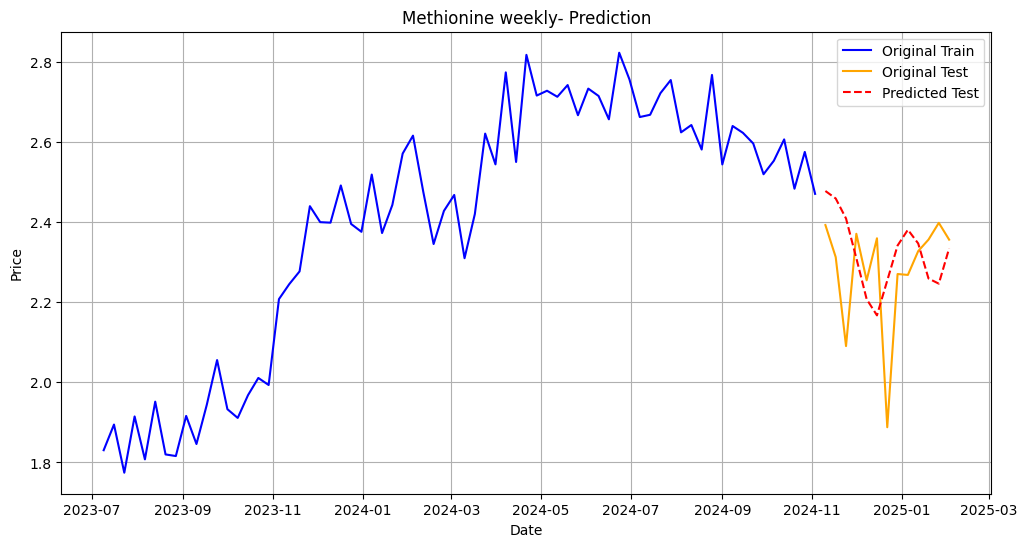

In [44]:
train_size = len(y_train)
test_size = len(y_test)
# Get the date ranges
train_dates = df['Date'][ws:train_size + ws]
test_dates = df['Date'][train_size + ws:train_size + ws + train_size + test_size]

# Plot
plt.figure(figsize=(12, 6))
plt.style.use('default')
plt.plot(train_dates, y_train, label='Original Train', color = 'blue')
plt.plot(test_dates, y_test, label='Original Test', color = 'orange')
plt.plot(test_dates, y_test_pred, label='Predicted Test', linestyle='--', color = 'Red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Methionine weekly- Prediction')
plt.legend()
plt.grid(True)
plt.show()

#Get x days ahead worth of predictions

In [45]:
def predict_future(model, initial_input, future_steps, scaler):
    """
    Predict future time steps using a trained LSTM model and inverse transform predictions if needed.

    :param model: Trained LSTM model
    :param initial_input: Torch tensor, last input sequence from the dataset
    :param future_steps: Number of future steps to predict
    :param scaler: Scaler used for normalization (e.g., MinMaxScaler). If None, assumes no scaling
    :return: Numpy array of future predictions in the original scale
    """
    model.eval()  # Set the model to evaluation mode
    predictions = []
    input_seq = initial_input.clone()  # Clone the input to avoid modifying the original

    with torch.no_grad():
        for step in range(future_steps):
            # Add batch dimension if needed
            if len(input_seq.shape) == 2:
                input_seq = input_seq.unsqueeze(0)  # Shape: (1, seq_len, input_dim)

            # Predict the next value
            pred = model(input_seq)  # Output shape: (1, output_dim) or (1, seq_len, output_dim)

            # Handle output dimensions dynamically
            if pred.dim() == 3:  # [batch_size, seq_len, output_dim]
                next_value = pred[:, -1, :]  # Get the last predicted value
            elif pred.dim() == 2:  # [batch_size, output_dim]
                next_value = pred  # Directly use the output

            # Add sequence dimension to next_value: [batch_size, 1, output_dim]
            next_value = next_value.unsqueeze(1)

            # Append to predictions
            predictions.append(next_value.squeeze().item())

            # Update input_seq by dropping the first time step and appending next_value
            input_seq = torch.cat((input_seq[:, 1:, :], next_value), dim=1)

    # Convert to numpy array
    predictions = np.array(predictions).reshape(-1, 1)  # Reshape for scaler

    # Debug: Check predictions before inverse transform
    print("Scaled predictions:", predictions[:5])
    #predictions = scaler.inverse_transform(predictions).flatten()
    # Inverse transform if a scaler was used
    #if scaler:
    predictions = scaler.inverse_transform(predictions).flatten()  # Convert back to original scale

    # Debug: Check predictions after inverse transform
    print("Inverse transformed predictions:", predictions[:5])

    return predictions

In [47]:
future_steps = 90
initial_input = x_test_torch[-1]  # Use the last input sequence from the test set
future_predictions = predict_future(model, initial_input, future_steps, scaler)
#future_predictions = scaler.inverse_transform(future_predictions).flatten()
import pandas as pd
last_date = pd.to_datetime(df['Date'].iloc[-1])
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, future_steps + 1)]
future_dates = pd.to_datetime(future_dates)

Scaled predictions: [[0.50843149]
 [0.590684  ]
 [0.63802654]
 [0.6762203 ]
 [0.71390206]]
Inverse transformed predictions: [2.33434293 2.4317812  2.4878643  2.53310953 2.57774824]


In [48]:
future_predictions = pd.DataFrame(future_predictions, columns=['Price'], index=future_dates)
future_predictions

,Price
2025-02-03,2.334343
2025-02-04,2.431781
2025-02-05,2.487864
2025-02-06,2.533110
2025-02-07,2.577748
...,...
2025-04-29,2.794998
2025-04-30,2.783869
2025-05-01,2.772458
2025-05-02,2.761640


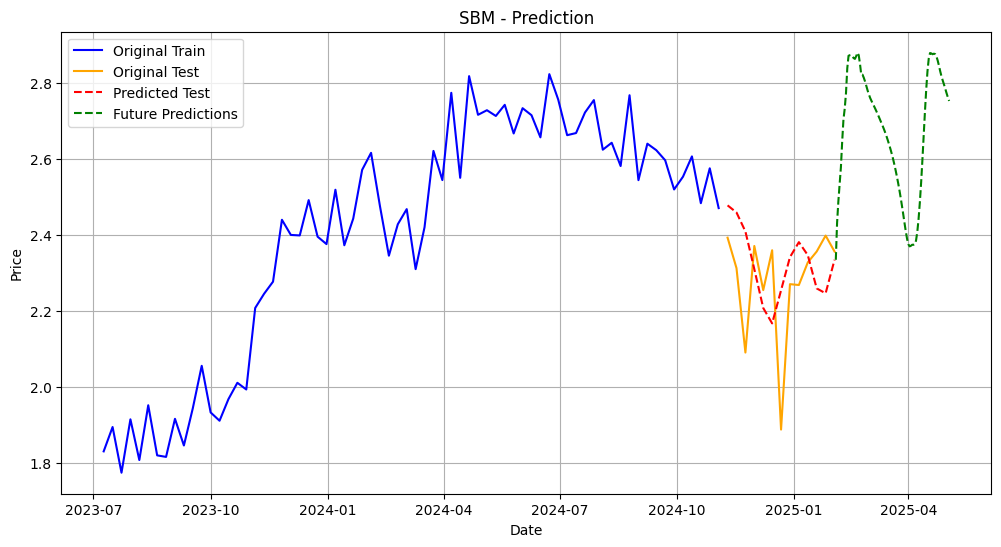

In [49]:
plt.figure(figsize=(12, 6))
plt.style.use('default')
plt.plot(train_dates, y_train, label='Original Train', color = 'blue')
plt.plot(test_dates, y_test, label='Original Test', color = 'orange')
plt.plot(test_dates, y_test_pred, label='Predicted Test', linestyle='--', color = 'Red')
plt.plot(future_dates, future_predictions, label='Future Predictions', linestyle='--', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SBM - Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
  #Detach all torch tensors
  x_train_torch = x_train_torch.cpu().detach().numpy()
  x_test_torch = x_test_torch.cpu().detach()
  y_train_torch = y_train_torch.cpu().detach().numpy()
  y_test_torch = y_test_torch.cpu().detach().numpy()

# not in use -
x days testing


In [ ]:
predictions = []
future_dates = 90  # Number of future days to predict
window_size = 30    # The size of the sliding window
current_window = df['Price'][-window_size:].to_numpy()
current_window = current_window.reshape(1, window_size, 1)  # Reshape for LSTM input: (batch_size, sequence_length, input_dim)

for i in range(future_dates):
    # Convert current window to a torch tensor and move it to GPU if using CUDA
    current_window_torch = torch.from_numpy(current_window).type(torch.FloatTensor).cuda()

    # Make prediction using the model
    predicted_value = model(current_window_torch)

    # Move predicted value back to CPU and detach it from the computation graph
    predicted_value = predicted_value.cpu().detach().numpy()  # Use .cpu() before .numpy()

    # Append the predicted value (reshape if necessary to match window shape)
    predictions.append(predicted_value)
    current_window = np.append(current_window, predicted_value)  # Append predicted value to the window
    current_window = current_window[-window_size:].reshape(1, window_size, 1)  # Keep the window size fixed

# Convert predictions back to the original scale if they were scaled during preprocessing
predictions = scaler.inverse_transform(np.array(predictions).reshape(future_dates, 1))

# Reshape and format predictions into a DataFrame
predictions = predictions.reshape(future_dates)
predictions = pd.DataFrame(predictions, columns=['Price'])

# Set the index of the DataFrame to future dates starting from '2025-02-01'
predictions.index = pd.date_range(start='2025-02-01', periods=future_dates, freq='D')

# Display the DataFrame
print(predictions)


               Price
2025-02-01  2.383741
2025-02-02  2.388193
2025-02-03  2.394945
2025-02-04  2.409215
2025-02-05  2.424250
...              ...
2025-04-27  2.599133
2025-04-28  2.599841
2025-04-29  2.600533
2025-04-30  2.601213
2025-05-01  2.601878

[90 rows x 1 columns]


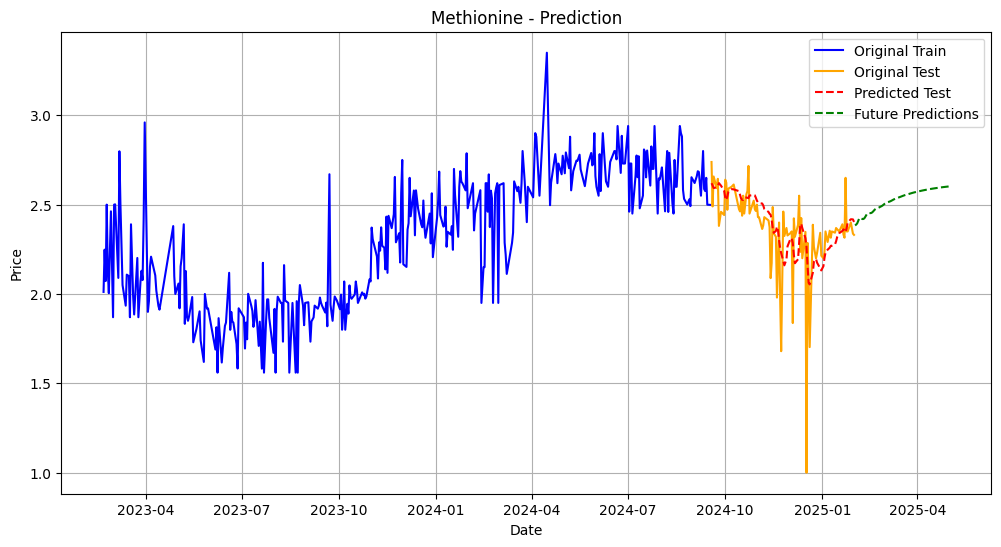

In [ ]:
plt.figure(figsize=(12, 6))
plt.style.use('default')
plt.plot(train_dates, y_train, label='Original Train', color = 'blue')
plt.plot(test_dates, y_test, label='Original Test', color = 'orange')
plt.plot(test_dates, y_test_pred, label='Predicted Test', linestyle='--', color = 'Red')
plt.plot(predictions['Price'], label='Future Predictions', linestyle='--', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Methionine - Prediction')
plt.legend()
plt.grid(True)
plt.show()